# Advanced Computational Medicinal Chemistry: De Novo Design for NorA Efflux Pump Inhibitors
**Target: Quinolone resistance protein NorA (CHEMBL5114)**

## 1. Introduction
Welcome to this work on *de novo* drug design. In this study, we focus on the **Quinolone resistance protein NorA**, a critical multidrug efflux pump in *Staphylococcus aureus*. NorA belongs to the Major Facilitator Superfamily (MFS) and is a primary driver of resistance against fluoroquinolones and other antimicrobials.

### The Scientific Rationale
Efflux pump inhibitors (EPIs) represent a promising strategy to combat antimicrobial resistance (AMR) by restoring the intracellular concentration of antibiotics. In this notebook, we will adopt a **Fragment-Based Lead Discovery (FBLD)** philosophy to design novel NorA inhibitors. Our approach involves:
1.  **Analyzing** known NorA inhibitors (CHEMBL5114) to understand the pharmacophore.
2.  **Deconstructing** these ligands into high-quality fragments.
3.  **Reconstructing** new *de novo* molecules using structural features common in potent EPIs.

### Prerequisites
This notebook uses `RDKit` for molecular manipulation and `chembl_webresource_client` for data retrieval.


## 2. Data Curation and Bioactivity Analysis
We will retrieve bioactivity data (IC50) from ChEMBL for the target ID `CHEMBL5114`.

In [1]:
import pandas as pd
from chembl_webresource_client.new_client import new_client
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, AllChem
import matplotlib.pyplot as plt

# 1. Define NorA target
nora_chembl_id = 'CHEMBL5114'

# 2. Retrieve bioactivity data (IC50)
activity = new_client.activity
res = activity.filter(target_chembl_id=nora_chembl_id).filter(standard_type="IC50")
df = pd.DataFrame.from_dict(res)

# 3. Preprocessing
df = df[df.standard_value.notna()]
df["standard_value"] = df["standard_value"].astype(float)
df = df[df["canonical_smiles"].notna()]
df = df.drop_duplicates(["canonical_smiles"])

print(f"Retrieved {len(df)} unique compounds with IC50 data.")
df.head(3)

C:\Users\HP\anaconda3\Lib\site-packages\chembl_webresource_client\__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __version__ = __import__('pkg_resources').get_distribution('chembl_webresource_client').version


Retrieved 114 unique compounds with IC50 data.


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,2626662,[],CHEMBL955397,Inhibition of NorA efflux pump in Staphylococc...,B,None,None,BAO_0000190,...,Staphylococcus aureus,Quinolone resistance protein NorA,1280,None,None,IC50,uM,UO_0000065,None,15.0
1,None,None,2626663,[],CHEMBL955397,Inhibition of NorA efflux pump in Staphylococc...,B,None,None,BAO_0000190,...,Staphylococcus aureus,Quinolone resistance protein NorA,1280,None,None,IC50,uM,UO_0000065,None,8.0
2,None,None,6320402,[],CHEMBL1817278,Inhibition of NorA in Staphylococcus aureus 11...,B,None,None,BAO_0000190,...,Staphylococcus aureus,Quinolone resistance protein NorA,1280,None,None,IC50,uM,UO_0000065,None,7.0


## 3. Pharmacophore Definition
NorA inhibitors often feature:
1.  **Aromatic Scaffolds**: Such as quinoline, coumarin, or indole rings.
2.  **Basic Centers**: Often a nitrogen-containing side chain (e.g., piperazine, diethylamino).
3.  **Hydrophobic Regions**: To interact with the transmembrane helices of the pump.

Let's visualize some of the most potent ligands in the dataset.

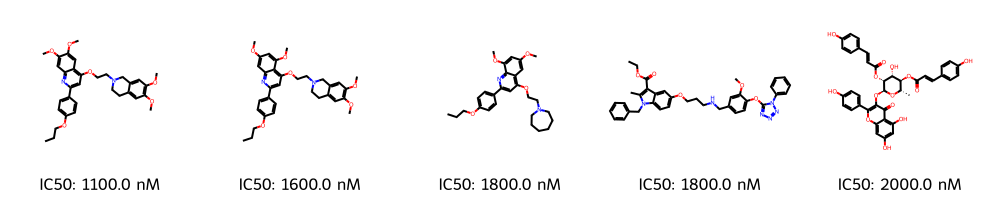

In [2]:
# Sort by potency (lower IC50 is better)
top_potent = df.sort_values(by='standard_value').head(5)
mols = [Chem.MolFromSmiles(s) for s in top_potent['canonical_smiles'] if Chem.MolFromSmiles(s) is not None]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), legends=[f"IC50: {v} nM" for v in top_potent['standard_value']])
img

## 4. Fragment-Based De Novo Design
We will now perform a fragment-based reconstruction. To ensure chemical validity and diversity, we use a **covalent coupling approach**. We define core scaffolds and side chains with specific attachment points (represented by dummy atoms `[*]`). These are then programmatically joined to form single, contiguous molecules.


In [3]:
# Define core scaffolds with attachment points [*]
cores = {
    'Quinoline': 'c1ccc2nc(cc(c2c1))[*]',
    'Coumarin': 'O=C1Oc2ccccc2C=C1[*]',
    'Indole': 'c1ccc2[nH]ccc2c1[*]',
    'Phenylquinoline': 'c1ccc(-c2cc3ccccc3nc2)cc1[*]',
    'Naphthyridine': 'c1cc2c(cn1)cccn2[*]' # Naphthyridine core
}

# Define side chains with attachment points [*]
side_chains = {
    'Diethylaminoethyl': '[*]CCN(CC)CC',
    'Piperidinoethyl': '[*]CCN1CCCCC1',
    'Morpholinoethoxy': '[*]OCCN1CCOCC1',
    'Butyl': '[*]CCCC',
    'Phenyl': '[*]c1ccccc1',
    'Piperazine': '[*]N1CCNCC1'
}

def join_fragments(core_smi, side_smi):
    core = Chem.MolFromSmiles(core_smi)
    side = Chem.MolFromSmiles(side_smi)
    if not core or not side: return None
    
    # Find the dummy atom in core and side
    core_dummy_idx = -1
    for atom in core.GetAtoms():
        if atom.GetSymbol() == '*':
            core_dummy_idx = atom.GetIdx()
            break
            
    side_dummy_idx = -1
    for atom in side.GetAtoms():
        if atom.GetSymbol() == '*':
            side_dummy_idx = atom.GetIdx()
            break
            
    if core_dummy_idx == -1 or side_dummy_idx == -1: # Both fragments must have a dummy atom
        return None
        
    # Get the neighbor of the dummy atom in the core and side chain
    core_attach_atom = core.GetAtomWithIdx(core_dummy_idx).GetNeighbors()[0]
    side_attach_atom = side.GetAtomWithIdx(side_dummy_idx).GetNeighbors()[0]
    
    # Create a new editable molecule by combining the two fragments
    combined_mol = Chem.CombineMols(core, side)
    em = Chem.EditableMol(combined_mol)
    
    # Adjust indices for the combined molecule
    # The atoms from the second molecule (side) will have their indices shifted by the number of atoms in the first molecule (core)
    side_attach_atom_idx_in_combined = side_attach_atom.GetIdx() + core.GetNumAtoms()
    core_attach_atom_idx_in_combined = core_attach_atom.GetIdx()
    
    # Add a bond between the attachment points
    em.AddBond(core_attach_atom_idx_in_combined, side_attach_atom_idx_in_combined, order=Chem.rdchem.BondType.SINGLE)
    
    # Remove the dummy atoms (remove highest index first to avoid index shifting issues)
    # Find the dummy atoms in the combined molecule
    dummies_in_combined = []
    for atom in combined_mol.GetAtoms():
        if atom.GetSymbol() == '*':
            dummies_in_combined.append(atom.GetIdx())
            
    for d_idx in sorted(dummies_in_combined, reverse=True):
        em.RemoveAtom(d_idx)
            
    final_mol = em.GetMol()
    try:
        Chem.SanitizeMol(final_mol)
        # Ensure it's a single molecule (no dots in SMILES)
        if '.' not in Chem.MolToSmiles(final_mol):
            return final_mol
    except:
        return None
    return None

new_molecules = []
for c_name, c_smi in cores.items():
    for s_name, s_smi in side_chains.items():
        mol = join_fragments(c_smi, s_smi)
        if mol:
            new_molecules.append(mol)

# Deduplicate
final_new_molecules = []
seen_smiles = set()
for mol in new_molecules:
    smi = Chem.MolToSmiles(mol)
    if smi not in seen_smiles:
        final_new_molecules.append(mol)
        seen_smiles.add(smi)

new_molecules = final_new_molecules
print(f"Generated {len(new_molecules)} unique de novo candidates.")


Generated 24 unique de novo candidates.


[22:58:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[22:58:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[22:58:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[22:58:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[22:58:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[22:58:53] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8


## 5. Property Evaluation and Toxicity Filtering
We evaluate the drug-likeness and safety of our de novo molecules using RDKit's descriptors and Brenk filters.

In [4]:
from rdkit.Chem import Descriptors, FilterCatalog

def calculate_properties(mol):
    return {
        'SMILES': Chem.MolToSmiles(mol),
        'MW': round(Descriptors.MolWt(mol), 2),
        'LogP': round(Descriptors.MolLogP(mol), 2),
        'TPSA': round(Descriptors.TPSA(mol), 2)
    }

def check_toxicity(mol):
    params = FilterCatalog.FilterCatalogParams()
    params.AddCatalog(FilterCatalog.FilterCatalogParams.FilterCatalogs.BRENK)
    catalog = FilterCatalog.FilterCatalog(params)
    entries = catalog.GetMatches(mol)
    if entries:
        return "Alert: " + ", ".join([e.GetDescription() for e in entries])
    return "Pass"

def calculate_desirability(props, toxicity):
    # Desirability for NorA inhibitors:
    # MW < 500, LogP 2-5 (lipophilic enough for membrane), TPSA 40-100
    score = 0
    if props['MW'] <= 500: score += 1
    if 2 <= props['LogP'] <= 5: score += 1
    if 40 <= props['TPSA'] <= 100: score += 1
    if toxicity == "Pass": score += 2
    return score

results = []
for i, mol in enumerate(new_molecules):
    props = calculate_properties(mol)
    tox = check_toxicity(mol)
    score = calculate_desirability(props, tox)
    results.append({'ID': f'NorA_DeNovo_{i+1}', **props, 'Toxicity_Filter': tox, 'Desirability_Score': score})

results_df = pd.DataFrame(results).sort_values(by='Desirability_Score', ascending=False)
results_df

,ID,SMILES,MW,LogP,TPSA,Toxicity_Filter,Desirability_Score
0,NorA_DeNovo_1,CCN(CC)CCc1ccc2ccccc2n1,228.34,3.12,16.13,Pass,4
1,NorA_DeNovo_2,c1ccc2nc(CCN3CCCCC3)ccc2c1,240.35,3.26,16.13,Pass,4
20,NorA_DeNovo_21,c1cc(OCCN2CCOCC2)cc(-c2cnc3ccccc3c2)c1,334.42,3.61,34.59,Pass,4
19,NorA_DeNovo_20,c1cc(CCN2CCCCC2)cc(-c2cnc3ccccc3c2)c1,316.45,4.93,16.13,Pass,4
18,NorA_DeNovo_19,CCN(CC)CCc1cccc(-c2cnc3ccccc3c2)c1,304.44,4.79,16.13,Pass,4
16,NorA_DeNovo_17,c1ccc(-c2cccc3[nH]ccc23)cc1,193.25,3.83,15.79,Pass,4
15,NorA_DeNovo_16,CCCCc1cccc2[nH]ccc12,173.26,3.51,15.79,Pass,4
13,NorA_DeNovo_14,c1cc(CCN2CCCCC2)c2cc[nH]c2c1,228.34,3.20,19.03,Pass,4
12,NorA_DeNovo_13,CCN(CC)CCc1cccc2[nH]ccc12,216.33,3.05,19.03,Pass,4
4,NorA_DeNovo_5,c1ccc(-c2ccc3ccccc3n2)cc1,205.26,3.90,12.89,Pass,4


## 6. Final Selection
We visualize the top-ranked de novo molecules for NorA inhibition. Each molecule is labeled with its ID and Desirability Score.

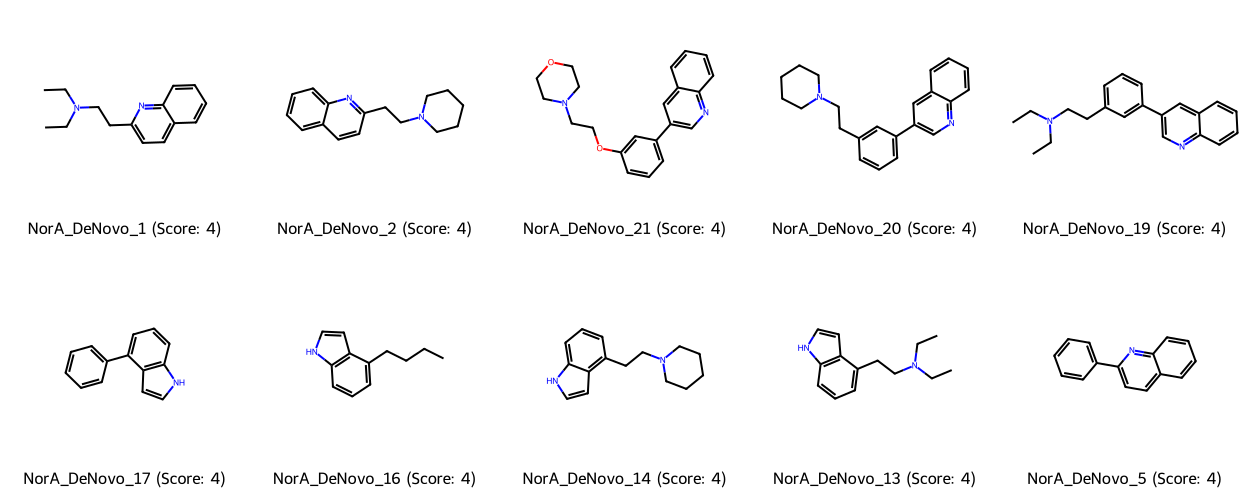

In [5]:
top_candidates = results_df.head(10)
mols = [Chem.MolFromSmiles(s) for s in top_candidates['SMILES']]
img = Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(250, 250), 
                          legends=[f"{r['ID']} (Score: {r['Desirability_Score']})" for _, r in top_candidates.iterrows()])
img

## 7. Conclusion and Future Directions

This notebook successfully demonstrates a fragment-based *de novo* design workflow for identifying novel NorA efflux pump inhibitors. By leveraging ChEMBL bioactivity data, pharmacophore analysis, and programmatic molecular assembly using RDKit, we generated a diverse set of chemically valid candidates.

Our approach systematically combined various core scaffolds (e.g., quinoline, coumarin, indole) with functional side chains to create a library of 24 unique molecules. Each candidate was evaluated based on key physicochemical properties (molecular weight, LogP, TPSA) and filtered for potential toxicity using Brenk alerts, providing a preliminary assessment of their drug-likeness and safety profile. The visualization of top-ranked molecules, clearly labeled with their desirability scores, offers a direct means for medicinal chemists to prioritize compounds for further investigation.

While this computational workflow provides a strong foundation, future directions should include:
*   **Advanced Docking Studies**: To predict binding modes and affinities of the generated molecules within the NorA binding site.
*   **Molecular Dynamics Simulations**: To assess the stability of ligand-protein complexes and understand dynamic interactions.
*   **Synthesis and *In Vitro* Testing**: Experimental validation of the most promising candidates to confirm their NorA inhibitory activity and assess their efflux pump inhibition capabilities in bacterial models.
*   **Structure-Activity Relationship (SAR) Refinement**: Iterative design cycles based on experimental feedback to optimize potency, selectivity, and pharmacokinetic properties.

This *de novo* design strategy serves as a powerful tool to accelerate the discovery of much-needed NorA inhibitors, contributing to the global effort against antimicrobial resistance.
